In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d248291f07839f3b2da69f9d4ffa7113e0a6320a8fa255859b7c8178223c8419
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=468eab88f854dd064823a0c3c3ff9f4d76e792cc6bf067cc0a4963958497ff89
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [3]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


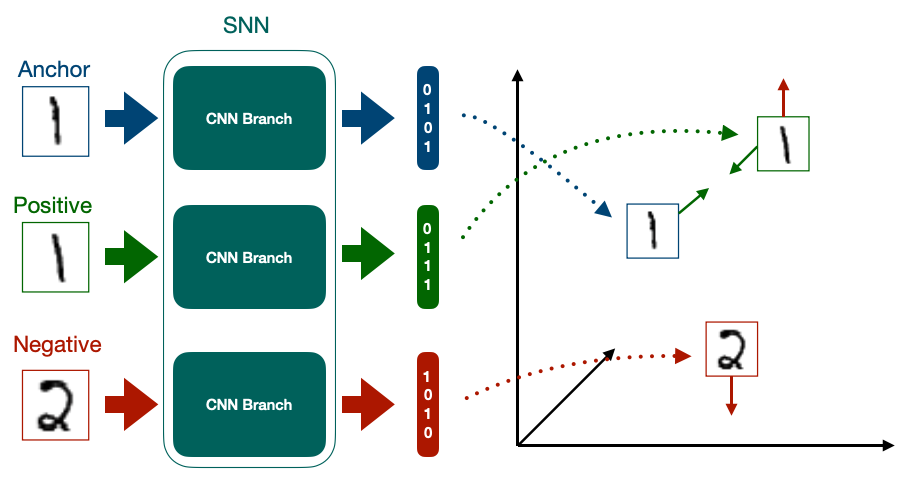

# Imports

In [4]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [7]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [9]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

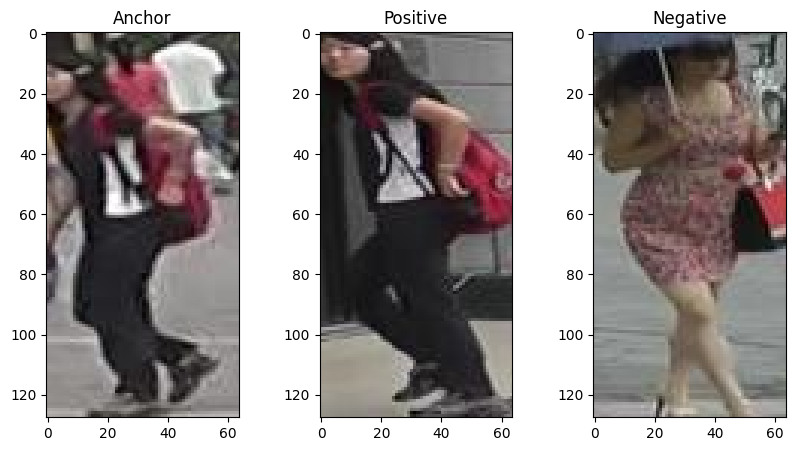

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [12]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Create APN Dataset

In [18]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 225.0

    return A_img, P_img, N_img

In [19]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


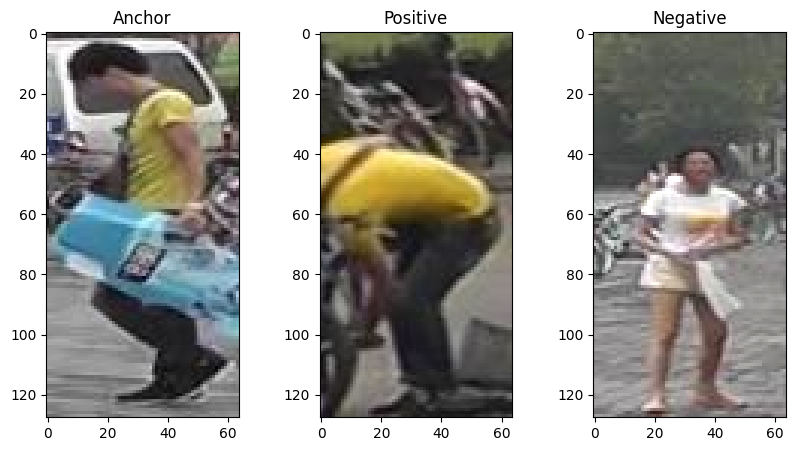

In [20]:
idx = 40
A_img,P_img,N_img = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P_img.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N_img.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [21]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)


In [22]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [23]:
for A_img, P_img, N_img in trainloader:
  break;

print(f"One image batch shape : {A_img.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [26]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings =self.efficientnet(images)

    return embeddings

In [33]:
model = APN_Model()
model.to(DEVICE)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Create Train and Eval function

In [37]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  totl_loss = 0.0

  for A_img, P_img, N_img in tqdm(dataloader):
    A_img, P_img, N_img =A_img.to(DEVICE), P_img.to(DEVICE), N_img.to(DEVICE)

    A_embs = model(A_img)
    P_embs = model(P_img)
    N_embs = model(N_img)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    return total_loss / len(dataloader)

In [38]:
def eval_fn(model, dataloader, criterion):
  model.eval() #OFF Dropout
  totl_loss = 0.0
  with torch.no_grad():
    for A_img, P_img, N_img in tqdm(dataloader):
      A_img, P_img, N_img =A_img.to(DEVICE), P_img, N_img.to(DEVICE)

      A_embs = model(A_img)
      P_embs = model(P_img)
      N_embs = model(N_img)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

      return total_loss / len(dataloader)

In [39]:
criterion = nn.TripletMarginLoss
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [40]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCES")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Get Anchor Embeddings

In [46]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A_img = io.imread(DATA_DIR + i)
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      A_img = A_img.to(DEVICE)
      A_enc = model(A_img.unsqueeze(0)) #(c, h, w) -> (l, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.contat([anc_img_names, encodings], axis = 1)

  return df_enc

In [47]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pt'

In [48]:
df_enc.to_csv('database.csv', index = False)
df.enc.head()

NameError: name 'df_enc' is not defined

# Inference

In [49]:
def euclidean_dist(img_enc, anc):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr,(img_enc - anc_enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR +img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [50]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_enc_img_names = df_enc['Ancor']

NameError: name 'df_enc' is not defined

In [51]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidiean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distznce = np.append(distance, dist)

NameError: name 'anc_enc_arr' is not defined

In [52]:
closeset_idx = np.argsort(distance)

In [53]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);

NameError: name 'anc_img_names' is not defined